# Super Resolution - Kelvins PROBA V - Deep Learning Approach

Each scene contains multiple images at Low Resolution and the goal is to obtain one single High Resolution image, therefore we can consider our task as a multiple image super resolution. But, each scene has a number non-fixed of images, so it can be difficult to realise a multi image super resolution using all images of our scene. (we know thought each scene has at least 9 images on Low Resolution). That is why, two main solutions are possible:
- solve the task using single image super resolution, then average the prediction on the clearest images of a scene.
- concatenate k fixed image. To select this k images, we can take the top k clearer images of a scene(and duplicate few of them if there are less than k image for a specific scene) -> multi image super resolution

So, the model used for single image super resolution will be implemented and tested on this dataset. Two architectures will be tested :
- SRCNN (Super Resolution Convolutionnal Neural Network) [[1]](https://arxiv.org/pdf/1501.00092.pdf)
- FSRCNN (Fast Super Resolution Convolutionnal Neural Network) [[2]](https://arxiv.org/pdf/1608.00367.pdf)

## SRCNN

The goal of this method is to learn an end to end mapping between low resolution images and high resolution images. The mapping takes as input the low resolution image which is upscale using a bicubic interpolation. The inputs feed then a deep neural network (CNN) which outputs the high resolution image. The intuition regarding the architecture of the CNN can be decomposed into 3 parts:
- patch extraction and representation: the process consists in extracting patches from the low-resolution image and represents each patch as a high dimensional vector using conventional filters. If we use a conventional layer with N filters, then each patch will contain a high dimensional vector of size N.
- non-linear mapping: this operation non linearly maps each high-dimensional vector onto another high dimensional vector (but reduce the dimensionality of the vector). Each mapped vector is the representation of a high-resolution patch.
- reconstruction: this operation aggregates the above high-resolution patches representations doing some kind of averaging in order to generate the final high-resolution image. This image is expected to be similar to the ground truth.

These three operations, which follow different intuitions are represented by the same operation in the CNN: convolution layer. In fact, the patch extraction is a convolution layer with 64 filters with a kernel of 9 x 9. The non linear mapping is represented by a convolution lawyer with 32 filters with a kernel 1 x 1 and the reconstruction by a convolution layer with C filters (corresponding to the number of channels of the image with High Resolution) with a kernel of n x n. The bigger is on and the better are the results. (we define n=5)

![image](image/srcnn.png)


An improvement of this simple version exists and is called SRCNN-EX [[3]](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.642.1999&rep=rep1&type=pdf) which increase the kernel size, of the second convolution layer from 1 to 5 (non linear mapping part). In general, the authors observe that the bigger the kernel size  is or the number of filters is, the better is the results.

## FSRCNN

The goal of FSRCNN was to accelerate the SRCNN architecture, and propose a CNN structure faster and better at Super Resolution task. The SRCNN structure is mainly different in three points :
- use smaller filter sizes but more mapping layers. 
- shrink the input feature dimension before the mapping using convolution layer with a kernel size, of 1 x 1. That permits to reduce the computing time. For instance, if the input feature map has a depth of d, then the convolution layer permitting to shrink these features need to have s filters with s d. After the mapping is done, the mapping is expanded. The goal is to increase the dimension of the feature vector in order to get better reconstruction for the generation of the High Resolution. To do that, we use the same approach than the shrinking, i.e using conventional layer but instead of having s filters (s << d) we have d filters.
- introduction of a deconvolution layer (called also transpose convolution) at the end of the network. The deconvolution will upsample and aggregate the previous features using a set of deconvolution filters. Therefore, the mapping is learned directly from the original Low Resolution image without bicubic interpolation, to the High Resolution one.

The extraction of features part is composed of a convolution layer with 56 filters and a kernel size of 5.
The shrinking part is composed of a convolution layer with 12 filters and a kernel size of 1.
The mapping part is composed of 4 convolution layers with 12 filters and a kernel size of 3. The expanding part is composed of a convolution layer with 56 filters and a kernel size of 1. And finally, the deconvolution part is composed of a deconvolution layer with C filters (corresponding to the number of channels desired) and a kernel size of 9.

![image](image/fsrcnn.png)

# Implementation :

What was try :

- train the different model using simple loss functions such as MSE (Mean Squarred Error) between only the HR image and SR image (predicted image). The result was bad for all of them, (more than 1.0 so worse than the bicubic interpolation baseline). The reason was that, the simple MSE loss function takes into account only the pixel in the prediction image and the high resolution image, but the clearer image (SM) is also important. The hypothesis is that knowing which pixel is important to reconstruct and which one is not (for instance the reconstruction of clouds is meaningless in our task) help to improve the precision of the model. Therefore, instead of using MSE function, using a function based on [cPSNR](https://kelvins.esa.int/proba-v-super-resolution/scoring/) is more appropriate. So the custom loss is such as Loss =  $\frac{N}{cPSNR}$. N = 46.5 represents the mean value of the norm provided in the csv file.

- two approachs of predictions were tested : 
    - multi image super resolution : for training or testing with this method, I take the top k low resolution images for each scene where the number of clear pixel is maximum (based on the QM image). The model will then predict an "High Resolution" based on the k low resolution images.
    - average single image super resolution : for training the model on single image as input, I take all images for each scene which have the maximum number of clear pixel (Quality Map image). Then the validation/testing is computing predicting on single low resolution image which have the maximum number of clearance pixel in a scene. If there are multiple low resolution images which have the same maximum number of clear pixel for a specific scene, I average the prediction.
    
    
- inputs images : Two images are available as input, the low resolution (LR) image and the clearance image (MQ, called map quality). Each of these image are in gray scale, so they have only one channel. Three approachs were tested :
    - use only the LR image. So the input does not know anything about clear pixel but it can deduce it because the output est the High Resolution image and its clearance image (SM)
    - combine the LR image with the clearance image. (multiply them) So, each unclear pixel (clouds for instance) will have a value of 0. That means the image will loss the information about unclear pixel and the intuition is that : it could help the model to not reconstruct meaningless information as clouds.
    - use the LR image and the clearance image. I concatenate these two images so instead of having an image with one channel, I will have two channel (one for the low resolution, one for the clearance). The intuition is the same as before, excepted that it will choose if it want to loose it or not. But, there will be twice the number of convolutions for the first convolutionnal layers compare to the previous proposition.



- for SRCNN : add convolution block from VGG16 in order to see if it can increase the results of SRCNN. (as features extractors)

- for FSRCNN : increase the kernel size to see if it performs better.

# Results (validation):

- use the custom loss based on cPSNR \& cMSE performs far better than simple MSE.
- the multi image super resolution approachs seems to have better results than averaging single image super resolution (based on SRCNN results). The hypothesis is that : when the multi image super resolution is used, it is possible to have different images with different clear part in each image. So the model may be able to combine the clear area in the different images in order to improve the reconstruction. 
- it seems there is not so much differences between using only LR image or concatenante LR and clearance image when the network has a certain depth (SRCNN with VGG convolution blocks) but we can see better results with only LR image with "small" CNN such as SRCNN/SRCNNex. 
- The better results I get using SRCNN/FSRCNN concept is using VGG16 conv blocks.




| Model          | Prediction           | Inputs            | Results validation    | Results Test |
| :------------- | :-------------------:|:----------------: |-----------: | ----------:|
|  SRCNN         | Average single image | Only LR           | <strong>0.99625 </strong>     |  |
|  SRCNN         | Average single image | Combine LR \& QM  | 0.99896     |  |
|  SRCNN         | Average single image | Concat LR \& QM   | 0.99745     |  |
|  SRCNN         | Multi image          | Only LR           | <strong>0.98961  </strong>   |  |
|  SRCNN         | Multi image          | Combine LR \& QM  | 0.99229     |  |
|  SRCNN         | Multi image          | Concat LR \& QM   | 0.99143     |  |
|  SRCNNex       | Multi image          | Only LR           | 0.98994     |  |
|  SRCNNex       | Multi image          | Concat LR \& QM   | <strong>0.98896    </strong>  |  |
|  FSRCNN        | Multi image          | Only LR           | 0.99134     | |
|  FSRCNN        | Multi image          | Concat  LR \& QM  | 0.99201     |   |
|  SRCNN - VGG16 | Multi image          | Concat  LR \& QM  | <strong>0.98886   </strong>   | <strong>0.984 </strong> |
|  SRCNN - VGG16 | Multi image          | Only LR           | <strong>0.98996   </strong>   |   |


- However we can see few artefacts generated by the model. The shape seems a bit better with the model than the bicubic model. There are improvement to do.

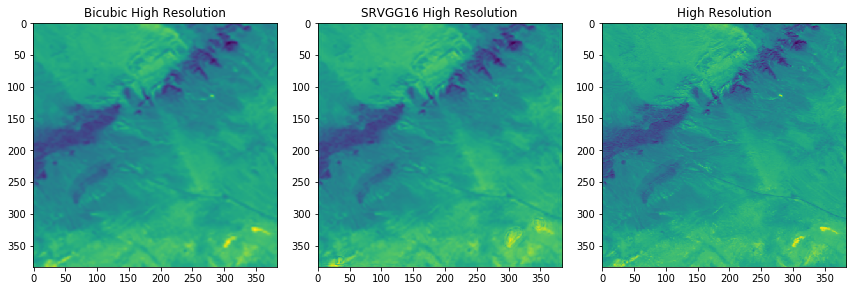

In [2]:
from functions_baseline_opencv import load_image2D
from matplotlib import pyplot as plt
opencvHR = load_image2D("image/imgset0594.png")
hr = load_image2D("image/HR_imgset0594.png")
preds_DL = load_image2D("image/SRVGG16_imgset0594.png")


fig = plt.figure(figsize=(12,12))
min_ = None
max_ = None
ax1 = fig.add_subplot(131); ax1.imshow(opencvHR, vmin=min_, vmax=max_); ax1.axis('on'); ax1.title.set_text('Bicubic High Resolution')
ax2 = fig.add_subplot(132); ax2.imshow(preds_DL, vmin=min_, vmax=max_); ax2.axis('on'); ax2.title.set_text('SRVGG16 High Resolution')
ax3 = fig.add_subplot(133); ax3.imshow(hr, vmin=min_, vmax=max_); ax3.axis('on'); ax3.title.set_text('High Resolution')

plt.tight_layout()

In [3]:
import keras
import cv2
import numba
from numba import prange

Using TensorFlow backend.


In [1]:
### Package
import cv2
import numpy as np
import os
import pandas as pd
import math
from skimage import io 
from skimage.transform import rescale
import skimage
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, Convolution2D, Conv2DTranspose
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import random
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.optimizers import SGD, Adam, Nadam
random.seed(20)
import time
import gc
import numba
from numba import prange #parallise loop
from generator import batch_generator_SRCNN, batch_generator_SRCNN_validation, load_image2D
from functions import load_data, preprocess_data, cPSNR_callback, compute_steps

K.clear_session()

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from keras.losses import binary_crossentropy

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

from sklearn.model_selection import train_test_split 
from model import FSRCNN, SRCNN, SRCNNex, SRCNNv2, SRVGG16, FSRCNNv2, SRCNNv3, SRResnet
from model import custom_loss, PSNR, MSE

Using TensorFlow backend.


# Training





In [7]:
# load train data
datas = load_data("data/train.txt")

data_train, data_val = train_test_split(datas, test_size=0.1, shuffle=True, 
                                        random_state=42)

# Parameters
multi_output=True # let it True, allow to use custom loss function (the output is the clearance image and HR image)
scale = 3 #upscale parameters
resize=True # use bicubic interpolation or not  to upscale before feeding CNN
with_clearance= False  # use clear image as input
type_clearance= "concat" # if yes, concat or "sum" (combine)
version=4 # version = 1 if we use the average single image approach, version = 4 if we use multi image approach
k=9
version_val = 1 if version !=4 else 4

batch_size=32
c = 1 if version != 4 else  k
channel = c*1 if with_clearance == False or type_clearance=="sum" else c*2 # number of channels
dim = 128 if resize == False else 128*scale

# preprocess data

train = preprocess_data(data_train, istrain=True,version=version, k = k)
val  = preprocess_data(data_val, istrain=True, version=version_val, k = k)

# parameters model
opt = Nadam(0.001) #optimizer

name_mod = "SRCNN_v4_noclearance_k9_concat.hdf5" # name of the model to save at each iteration
checkpoint = ModelCheckpoint(name_mod, verbose=2, monitor='val_cPSNR_'+str(version_val ), save_best_only=True, 
                             save_weights_only=False, mode='min')

lr_decay = ReduceLROnPlateau(monitor='val_cPSNR_'+str(version_val), factor=0.5, patience=5,  verbose=1, mode='min', 
                             epsilon=0.0001, cooldown=0, min_lr=0.000000001) 

model = SRCNN((dim, dim, channel), depth_multiplier=1, multi_output=multi_output)
# model = SRVGG16((dim, dim, channel), depth_multiplier=1, multi_output=multi_output)

model.summary()
if multi_output:
    model.compile(loss=custom_loss, optimizer=opt)
else:
    model.compile(loss=MSE, optimizer=opt)
    
# create batch
gen_train = batch_generator_SRCNN(train, batch_size=batch_size, with_clearance=with_clearance, type_clearance=type_clearance,
                                    version=version, shuffle=True, scale=scale, data_aug=False, resize=resize, multi_output=multi_output)
metrics = cPSNR_callback(val, with_clearance=with_clearance, type_clearance=type_clearance, version=version_val, 
                         scale=scale, resize=resize, name="val_", multi_output=multi_output)

steps_train=compute_steps(train, batch_size,  version=version)

# train model
model.fit_generator(gen_train, steps_per_epoch=steps_train, epochs=1, verbose=1, 
                    callbacks=[metrics, lr_decay, checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 384, 384, 9)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 384, 384, 64)      46720     
_________________________________________________________________
mapping (Conv2D)             (None, 384, 384, 32)      2080      
_________________________________________________________________
output (Conv2D)              (None, 384, 384, 2)       1602      
Total params: 50,402
Trainable params: 50,402
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1
preprocessing data version 4, concat imageset top k

33/33 [==============================] - 32s 962ms/step - loss: 1.2520
 - val_cPSNR_4: 1.03585 | - val_loss_mean_4 : 6.37614 | - time : 7.961689710617065 sec          

Epoch 00001: val_cPSNR_4 improved from

# Validation






In [17]:
from prediction import predict_results, get_validation_results
from keras.models import load_model
# load train data
datas = load_data("data/train.txt")

data_train, data_val = train_test_split(datas, test_size=0.1, shuffle=True, 
                                        random_state=42)


# Parameters
multi_output=True # let it True, allow to use custom loss function (the output is the clearance image and HR image)
scale = 3 #upscale parameters
resize=True # use bicubic interpolation or not  to upscale before feeding CNN
with_clearance= True  # use clear image as input
type_clearance= "concat" # if yes, concat or "sum" (combine)
version=4 # version = 1 if we use the average single image approach, version = 4 if we use multi image approach
k=9
version_val = 1 if version !=4 else 4

# preprocess data
train = preprocess_data(data_train, istrain=True,version=version,k=k)
val  = preprocess_data(data_val, istrain=True, version=version_val,k=k)

# name model to load
name_model ="SRVGG16_v4_withclearance_concat_multi_k9"#"SRCNNv1"#"FSRCNNv1_withclearance_sum"
formats = ".hdf5"
model = load_model(name_model+formats)

# validation
evaluate=True
if evaluate:
    get_validation_results(model, train, with_clearance=with_clearance,  multi_output=multi_output,
                       type_clearance=type_clearance, scale=scale, resize=resize, version=version)
    get_validation_results(model, val, with_clearance=with_clearance, multi_output=multi_output,
                       type_clearance=type_clearance, scale=scale, resize=resize, version=version)
    

 - cPSNR: 0.98849 | - time : 78.7902979850769 sec          
 - cPSNR: 0.98893 | - time : 8.92288064956665 sec          


# Testing

In [15]:
data_test = load_data("data/test.txt")
test = preprocess_data(data_test, istrain=False,version=version,k=k)

directory = "results/results_" + name_model

predict_results(model, test, directory, with_clearance=with_clearance, multi_output=multi_output,
                       type_clearance=type_clearance, scale=scale, resize=resize, version=version)

# Improvements to do :
- Use more layers in order to see if the results can be better
- Pretrained the model on satellite images